In [1]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

import pandas as pd
import os
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from evaluation.evaluation import get_pooled_aggregate_stats
from sklearn.model_selection import ParameterGrid
from scipy.stats import wilcoxon

```Python
for each dataset in {smd, arterial blood, nasa, ...}:
   for each cross-valid fold in range(5):
      selection = 20% of all entities
      evaluation = 80% of all entities

      oracle_method = select based on selection set
      oracle_result = perf of oracle_method on evaluation
      random_result = mean on evaluation set
      for each unsupervised ranking metric:
          ranking_method_i = select one model for all of evaluation
          ranking_result_i = perf of ranking_method_i on evaluation
```

In [2]:
with open('aggregate_stats_smd.pkl', 'rb') as f:
    aggregate_stats = pkl.load(f)

In [3]:
aggregate_stats.keys()

dict_keys(['NASA Data', 'Gait', 'Respiration Rate (RESP)', 'Acceleration Sensor Data', 'Air Temperature', 'Atrial Blood Pressure (ABP)', 'Electrocardiogram (ECG) Arrhythmia', 'Insect Electrical Penetration Graph (EPG)', 'Power Demand', 'SMD'])

In [4]:
aggregate_stats['NASA'] = aggregate_stats.pop('NASA Data')
aggregate_stats['Gait'] = aggregate_stats.pop('Gait')
aggregate_stats['RESP'] = aggregate_stats.pop('Respiration Rate (RESP)')
aggregate_stats['Acceleration'] = aggregate_stats.pop('Acceleration Sensor Data')
aggregate_stats['Temperature'] = aggregate_stats.pop('Air Temperature')
aggregate_stats['ABP'] = aggregate_stats.pop('Atrial Blood Pressure (ABP)')
aggregate_stats['ECG'] = aggregate_stats.pop('Electrocardiogram (ECG) Arrhythmia')
aggregate_stats['EPG'] = aggregate_stats.pop('Insect Electrical Penetration Graph (EPG)')
aggregate_stats['Power'] = aggregate_stats.pop('Power Demand')
aggregate_stats['SMD'] = aggregate_stats.pop('SMD')

/home/ubuntu/.local/lib/python3.9/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/ubuntu/.local/lib/python3.9/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/home/ubuntu/.local/lib/python3.9/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/ubuntu/.local/lib/python3.9/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/home/ubuntu/.local/lib/python3.9/site-packages/scipy/stats/_mores

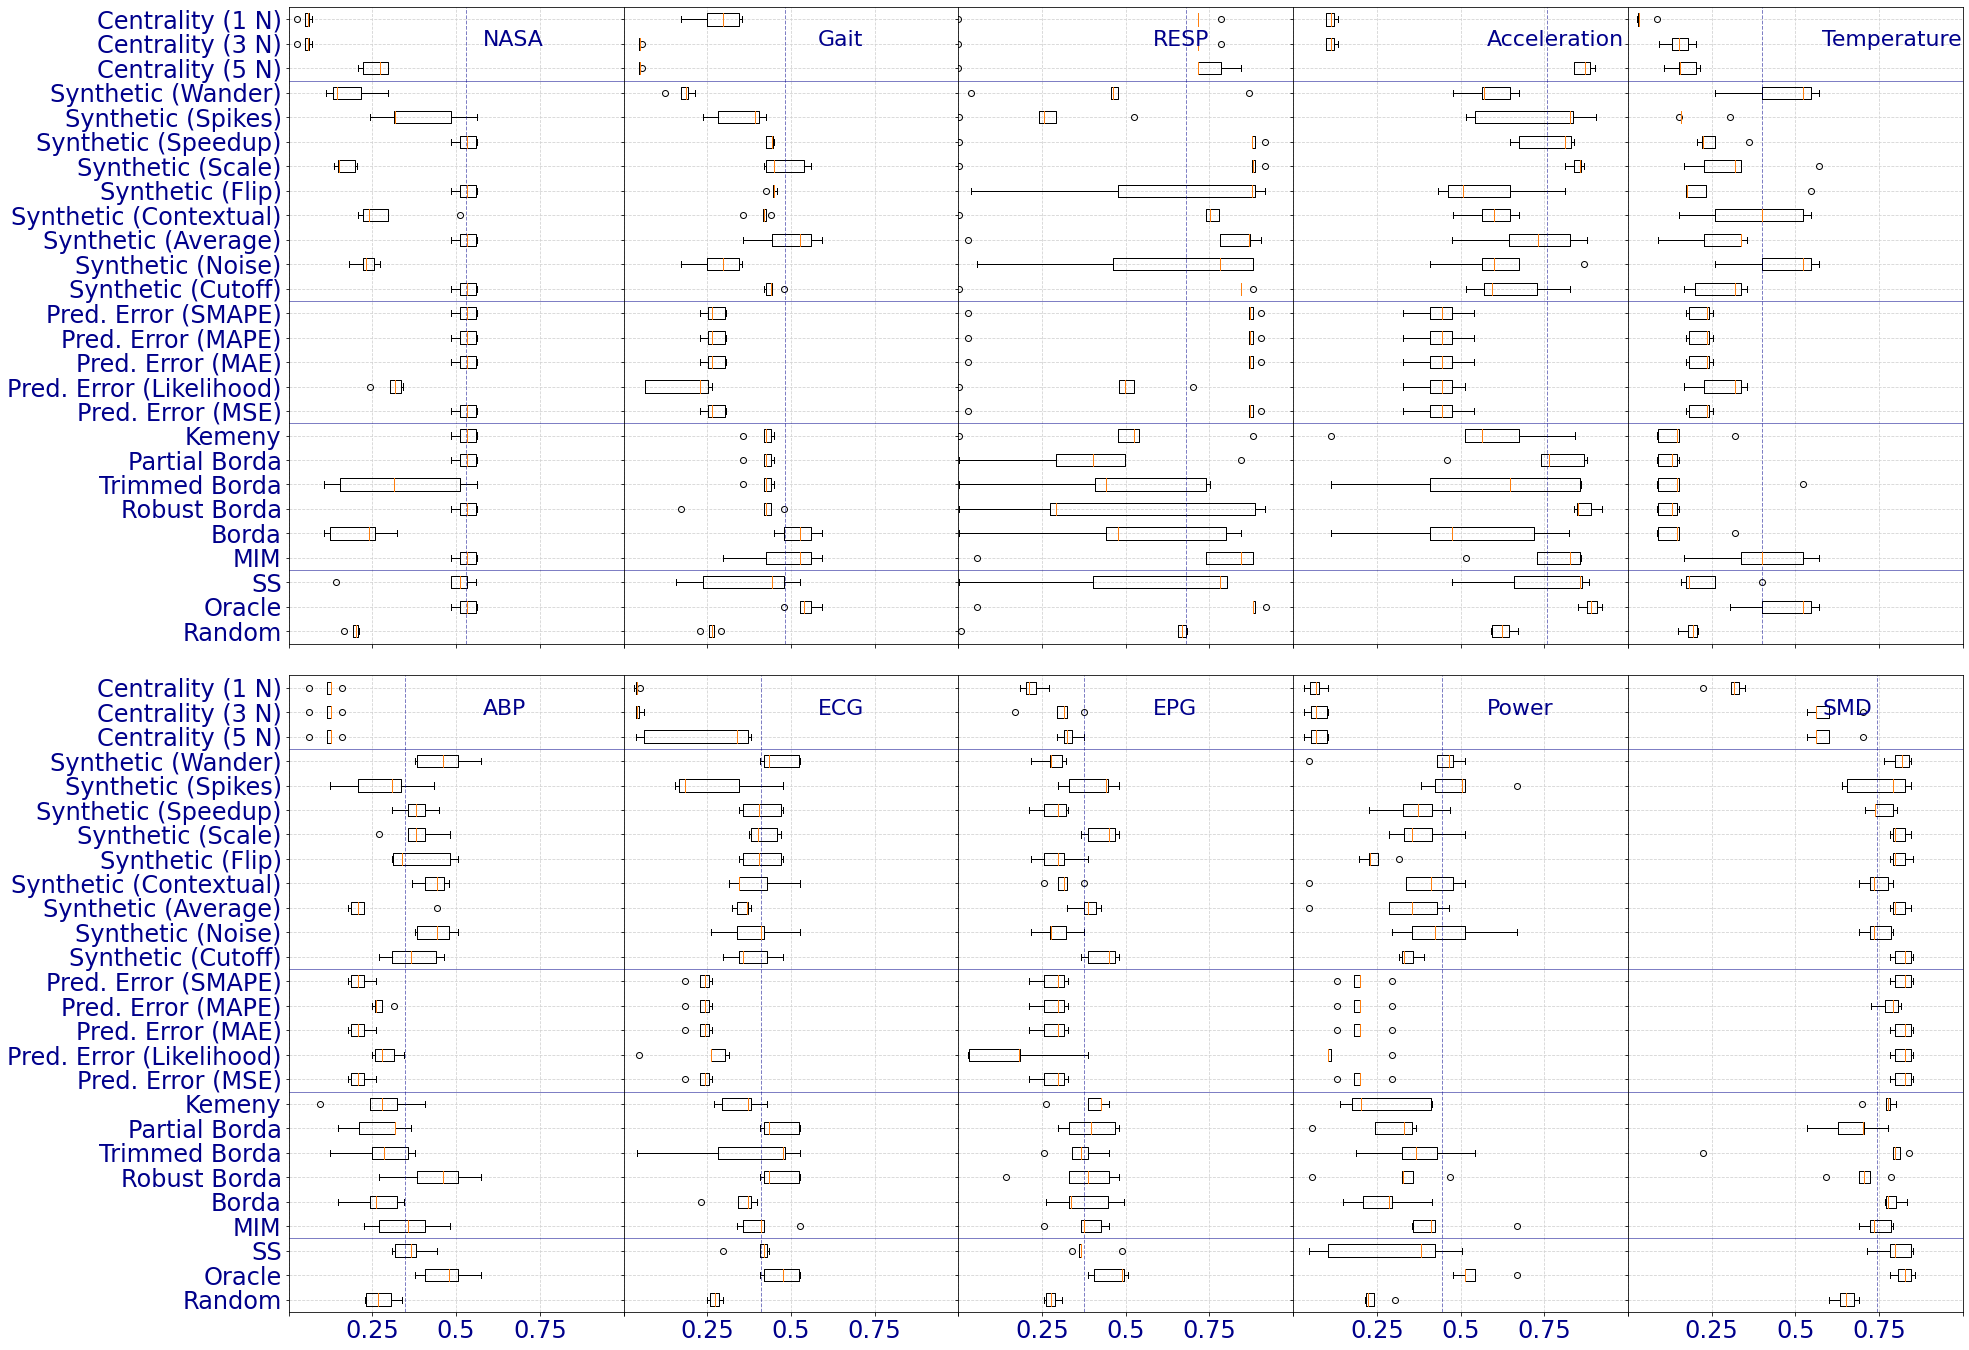

In [20]:
# plt.style.use('ggplot')
# fig, axes = plt.subplots(2, 5, figsize=(30, 12), sharey=True, sharex=True)
fig, axes = plt.subplots(2, 5, figsize=(30, 24), sharey=True, sharex=True)
axes = axes.flatten()
data_families = list(aggregate_stats.keys())
pairwise_comparisons = {}

for i, data_family in enumerate(data_families):

    PLOT_STATS = {
        # 'Random': aggregate_stats[data_family]['Random MS'],
        # 'Oracle': aggregate_stats[data_family]['Oracle MS'],
        # 'SS': aggregate_stats[data_family]['Oracle No-MS'],
        # # 'MIM': aggregate_stats[data_family]['Most Reliable Metric MS'],
        # 'MIM': aggregate_stats[data_family]['Most Reliable Metric (Partial) MS'],
        # 'Borda': aggregate_stats[data_family]['Borda MS'],
        # 'Robust Borda': aggregate_stats[data_family]['Partial Trimmed Partial Borda MS'], # NOTE <-- Partial Trimmed Borda instead of Partial Trimmed Partial Borda
        # 'Synthetic (Cutoff)': aggregate_stats[data_family]['SYNTHETIC_F1_cutoff MS'],
        # 'Synthetic (Noise)': aggregate_stats[data_family]['SYNTHETIC_F1_noise MS'],
        # 'Pred. Error (MSE)': aggregate_stats[data_family]['MSE MS'],

        ### Full Plot 
        'Random': aggregate_stats[data_family]['Random MS'],
        'Oracle': aggregate_stats[data_family]['Oracle MS'],
        'SS': aggregate_stats[data_family]['Oracle No-MS'],
        'MIM': aggregate_stats[data_family]['Most Reliable Metric (Partial) MS'],
        'Borda': aggregate_stats[data_family]['Borda MS'],
        'Robust Borda': aggregate_stats[data_family]['Partial Trimmed Partial Borda MS'], # NOTE <-- Partial Trimmed Borda instead of Partial Trimmed Partial Borda
        'Trimmed Borda': aggregate_stats[data_family]['Trimmed Borda MS'],
        'Partial Borda': aggregate_stats[data_family]['Partial Borda MS'],
        'Kemeny': aggregate_stats[data_family]['Kemeny MS'],
        'Pred. Error (MSE)': aggregate_stats[data_family]['MSE MS'],
        'Pred. Error (Likelihood)': aggregate_stats[data_family]['LIKELIHOOD MS'],
        'Pred. Error (MAE)': aggregate_stats[data_family]['MAE MS'],
        'Pred. Error (MAPE)': aggregate_stats[data_family]['MAPE MS'],
        'Pred. Error (SMAPE)': aggregate_stats[data_family]['SMAPE MS'],
        'Synthetic (Cutoff)': aggregate_stats[data_family]['SYNTHETIC_F1_cutoff MS'],
        'Synthetic (Noise)': aggregate_stats[data_family]['SYNTHETIC_F1_noise MS'],
        'Synthetic (Average)': aggregate_stats[data_family]['SYNTHETIC_F1_average MS'],
        'Synthetic (Contextual)': aggregate_stats[data_family]['SYNTHETIC_F1_contextual MS'],
        'Synthetic (Flip)': aggregate_stats[data_family]['SYNTHETIC_F1_flip MS'],
        'Synthetic (Scale)': aggregate_stats[data_family]['SYNTHETIC_F1_scale MS'],
        'Synthetic (Speedup)': aggregate_stats[data_family]['SYNTHETIC_F1_speedup MS'],
        'Synthetic (Spikes)': aggregate_stats[data_family]['SYNTHETIC_F1_spikes MS'],
        'Synthetic (Wander)': aggregate_stats[data_family]['SYNTHETIC_F1_wander MS'],
        'Centrality (5 N)': aggregate_stats[data_family]['CENTRALITY_6 MS'],
        'Centrality (3 N)': aggregate_stats[data_family]['CENTRALITY_4 MS'],
        'Centrality (1 N)': aggregate_stats[data_family]['CENTRALITY_2 MS'],
        
        # 'Partial Trimmed Borda': aggregate_stats[data_family]['Partial Trimmed Borda MS'],
        # 'Trimmed Kemeny': aggregate_stats[data_family]['Trimmed Kemeny MS'],
    }    
    # axes[i].set_title(f"{data_family}", fontsize=18)    
    
    _ = axes[i].boxplot(PLOT_STATS.values(), 
                    vert=False, 
                    bootstrap=10000,
                    # showmeans=True,
                    # meanline=True
                    )        
    
    # Making plots more readable (Partial)
    # axes[i].axvline(x=np.mean(aggregate_stats[data_family]['Most Reliable Metric (Partial) MS']), linewidth=1, c='darkblue', alpha=0.5, linestyle='--')
    # axes[i].axhline(y=3.5, linewidth=1, c='darkblue', alpha=0.5)
    # axes[i].axhline(y=6.5, linewidth=1, c='darkblue', alpha=0.5)
    # axes[i].grid(True, linestyle='--', color='lightgray')
    # axes[i].text(x=0.58, y=8.9, s=f"{data_family}", color='darkblue', size=22, fontfamily='sans-serif')
    # axes[i].set_yticks(np.arange(1, 27), minor=False)    

    # Making plots more readable (Full)
    axes[i].axvline(x=np.mean(aggregate_stats[data_family]['Most Reliable Metric (Partial) MS']), linewidth=1, c='darkblue', alpha=0.5, linestyle='--')
    axes[i].axhline(y=23.5, linewidth=1, c='darkblue', alpha=0.5)
    axes[i].axhline(y=14.5, linewidth=1, c='darkblue', alpha=0.5)
    axes[i].axhline(y=9.5, linewidth=1, c='darkblue', alpha=0.5)
    axes[i].grid(True, linestyle='--', color='lightgray')
    axes[i].text(x=0.58, y=24.9, s=f"{data_family}", color='darkblue', size=22, fontfamily='sans-serif')
    axes[i].set_yticks(np.arange(1, 27), minor=False)
    
    
    axes[i].axhline(y=3.5, linewidth=1, c='darkblue', alpha=0.5)
    axes[i].set_yticklabels(PLOT_STATS.keys(), minor=False, fontsize=24, color='darkblue')
    axes[i].set_xlim(0, 1)
    axes[i].set_xticks(np.linspace(0, 1., 5), minor=False)
    axes[i].set_xticklabels(['', '0.25', '0.5', '0.75', ''], minor=False, fontsize=24, color='darkblue')

    pairwise_comparisons[data_family] = {}

    # Make pairwise comparison table
    methods = list(PLOT_STATS.keys())

    for i in range(len(methods)):
        pairwise_comparisons[data_family][methods[i]] = {}
        for j in range(len(methods)):  
            differences = np.array(PLOT_STATS[methods[i]]) - np.array(PLOT_STATS[methods[j]])
            if np.sum(differences) < 1e-6:
                pvalue = np.NaN
            else:
                pvalue = wilcoxon(differences, alternative='greater').pvalue
                if pvalue < 0.05:
                    pairwise_comparisons[data_family][methods[i]][methods[j]] = pvalue
                else:
                    pairwise_comparisons[data_family][methods[i]][methods[j]] = np.NaN
        
    pairwise_comparisons[data_family] = pd.DataFrame(pairwise_comparisons[data_family])

plt.subplots_adjust(wspace=0, hspace=0.05)
plt.savefig(f"box_plot_pooled_stats_{datetime.today().strftime(r'%H-%M-%m-%d-%Y')}.pdf", bbox_inches='tight')
plt.show()

In [31]:
comparisons_random = []
comparisons_ss = []
comparisons_oracle = []
comparisons_borda = []
for data_family in pairwise_comparisons.keys():    
    ## Losses
    comparisons_borda.append(pd.notna(pairwise_comparisons[data_family]).loc[:, 'Borda']) # Total number of losses
    comparisons_random.append(pd.notna(pairwise_comparisons[data_family]).loc[:, 'Random']) # Significantly worse than Rondom Model Selection
    comparisons_oracle.append(pd.notna(pairwise_comparisons[data_family]).loc[:, 'Oracle']) # Significantly worse than Oracle
    comparisons_ss.append(pd.notna(pairwise_comparisons[data_family]).loc[:, 'SS']) # Significantly worse than Supervised Selection 

# Losses table
results_losses = pd.concat([
    # pd.concat(comparisons_borda, axis=1).sum(axis=1), # Number of losses
    pd.concat(comparisons_oracle, axis=1).sum(axis=1), # Significantly worse than Oracle
    pd.concat(comparisons_ss, axis=1).sum(axis=1), # Significantly worse than Supervised Selection
    pd.concat(comparisons_random, axis=1).sum(axis=1), # Significantly worse than Random MS
    ], axis=1)
# results.columns = ['Significant Losses', 'Worse than Oracle', 'Worse than Supervised Selection', 'Worse than Random MS']
# results_losses.columns = ['Worse than Borda', 'Worse than Oracle', 'Worse than Supervised Selection', 'Worse than Random MS']
results_losses.columns = ['Worse than Oracle', 'Worse than Supervised Selection', 'Worse than Random MS']
# results.loc[['Partial Trimmed Borda', 'Trimmed Borda', 'Synthetic (Noise)', 'Synthetic (Cutoff)', 'Synthetic (Scale)'], :]
# results.sort_values(by='Worse than Oracle')
results_losses
    

,Worse than Oracle,Worse than Supervised Selection,Worse than Random MS
Synthetic (Scale),7.0,0.0,0.0
Synthetic (Wander),6.0,1.0,1.0
Centrality (3 N),10.0,6.0,7.0
Centrality (1 N),10.0,7.0,7.0
Random,10.0,4.0,0.0
SS,7.0,0.0,0.0
Borda,9.0,3.0,0.0
Trimmed Borda,8.0,0.0,0.0
Pred. Error (Likelihood),9.0,3.0,2.0
Synthetic (Noise),6.0,0.0,0.0


In [33]:
comparisons_random = []
comparisons_ss = []
comparisons_oracle = []
comparisons_borda = []
for data_family in pairwise_comparisons.keys():
    ## Wins
    # comparisons.append(pd.notna(pairwise_comparisons[data_family]).sum(axis=0)) # Total number of wins
    comparisons_borda.append(pd.notna(pairwise_comparisons[data_family]).loc['Borda', :]) # Significantly better than Rondom Model Selection
    comparisons_random.append(pd.notna(pairwise_comparisons[data_family]).loc['Random', :]) # Significantly better than Rondom Model Selection
    comparisons_ss.append(pd.notna(pairwise_comparisons[data_family]).loc['SS', :]) # Significantly better than Supervised Selection

# Wins table
results_wins = pd.concat([
    # pd.concat(comparisons_borda, axis=1).sum(axis=1), # Number of wins
    pd.concat(comparisons_ss, axis=1).sum(axis=1), # Significantly better than Supervised Selection
    pd.concat(comparisons_random, axis=1).sum(axis=1), # Significantly better than Random MS
    ], axis=1)
# results.columns = ['Significant Wins', 'Better than Supervised Selection', 'Better than Random MS']
# results_wins.columns = ['Better than Borda', 'Better than Supervised Selection', 'Better than Random MS']
results_wins.columns = ['Better than Supervised Selection', 'Better than Random MS']
# results.loc[['Partial Trimmed Borda', 'Trimmed Borda', 'Synthetic (Noise)', 'Synthetic (Cutoff)', 'Synthetic (Scale)'], :]
# results.sort_values(by='Better than Random MS', ascending=False)
results_wins

,Better than Supervised Selection,Better than Random MS
Random,0,0
Oracle,7,10
SS,0,4
MIM,1,7
Borda,0,3
Robust Borda,0,4
Trimmed Borda,0,1
Partial Borda,0,4
Kemeny,0,4
Pred. Error (MSE),1,3


In [36]:
results = pd.concat([results_wins, results_losses], axis=1)
results

,Better than Supervised Selection,Better than Random MS,Worse than Oracle,Worse than Supervised Selection,Worse than Random MS
Random,0,0,10.0,4.0,0.0
Oracle,7,10,NaN,NaN,NaN
SS,0,4,7.0,0.0,0.0
MIM,1,7,6.0,0.0,0.0
Borda,0,3,9.0,3.0,0.0
Robust Borda,0,4,6.0,2.0,1.0
Trimmed Borda,0,1,8.0,0.0,0.0
Partial Borda,0,4,8.0,3.0,1.0
Kemeny,0,4,9.0,1.0,0.0
Pred. Error (MSE),1,3,8.0,4.0,4.0


In [52]:
latex_string = ""
for row in range(results.shape[0]):
    latex_string = latex_string + f'\\texttt' + '{' + results.index[row] + '} &'  
    for col in range(results.shape[1]):
        val = results.iloc[row, col]
        if val != val: 
            val = 0
        latex_string = latex_string + f' {int(val)}'

        if  col != results.shape[1] - 1: 
            latex_string = latex_string + ' & '
        else: 
            latex_string = latex_string + ' \\\ \n'

SyntaxError: f-string: single '}' is not allowed (2612347446.py, line 3)

In [51]:
print(latex_string)

 Random &  0 &  0 &  10 &  4 &  0 \\ 
 Oracle &  7 &  10 &  0 &  0 &  0 \\ 
 SS &  0 &  4 &  7 &  0 &  0 \\ 
 MIM &  1 &  7 &  6 &  0 &  0 \\ 
 Borda &  0 &  3 &  9 &  3 &  0 \\ 
 Robust Borda &  0 &  4 &  6 &  2 &  1 \\ 
 Trimmed Borda &  0 &  1 &  8 &  0 &  0 \\ 
 Partial Borda &  0 &  4 &  8 &  3 &  1 \\ 
 Kemeny &  0 &  4 &  9 &  1 &  0 \\ 
 Pred. Error (MSE) &  1 &  3 &  8 &  4 &  4 \\ 
 Pred. Error (Likelihood) &  0 &  3 &  9 &  3 &  2 \\ 
 Pred. Error (MAE) &  1 &  3 &  8 &  4 &  4 \\ 
 Pred. Error (MAPE) &  1 &  3 &  9 &  4 &  3 \\ 
 Pred. Error (SMAPE) &  1 &  3 &  8 &  4 &  4 \\ 
 Synthetic (Cutoff) &  1 &  8 &  8 &  0 &  0 \\ 
 Synthetic (Noise) &  2 &  5 &  6 &  0 &  0 \\ 
 Synthetic (Average) &  0 &  6 &  7 &  1 &  0 \\ 
 Synthetic (Contextual) &  1 &  5 &  7 &  0 &  0 \\ 
 Synthetic (Flip) &  0 &  5 &  8 &  0 &  0 \\ 
 Synthetic (Scale) &  1 &  8 &  7 &  0 &  0 \\ 
 Synthetic (Speedup) &  1 &  6 &  9 &  1 &  0 \\ 
 Synthetic (Spikes) &  0 &  3 &  8 &  1 &  1 \\ 
 Syntheti